In [1]:
!pip install pydicom pillow

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import math
import random
import shutil

import cv2
import pydicom
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed(42)

In [3]:
CSV_FILE = '../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
TRAIN_SRC_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
TEST_SRC_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images/'
DATASET_DIR = './dataset/'
TEST_IMG_DIR = 'test_images/'

os.mkdir(DATASET_DIR)
os.mkdir(DATASET_DIR + 'images/')
os.mkdir(DATASET_DIR + 'images/train/')
os.mkdir(DATASET_DIR + 'images/val/')
os.mkdir(DATASET_DIR + 'images/test/')
os.mkdir(DATASET_DIR + 'labels/')
os.mkdir(DATASET_DIR + 'labels/train/')
os.mkdir(DATASET_DIR + 'labels/val/')
os.mkdir(DATASET_DIR + 'labels/test/')
os.mkdir(TEST_IMG_DIR)

In [4]:
annots = pd.read_csv(CSV_FILE)
annots = annots[annots.Target == 1]
annots.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [5]:
patient_id_series = annots.patientId.drop_duplicates()

train_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=42)
print('Train set number:', len(train_series))
print('Validation set number:', len(val_series))

Train set number: 5410
Validation set number: 602


In [6]:
for patient_id in train_series:
    src_path = TRAIN_SRC_DIR + patient_id + '.dcm'
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(DATASET_DIR + 'images/train/' + patient_id + '.jpg')
    
for patient_id in val_series:
    src_path = TRAIN_SRC_DIR + patient_id + '.dcm'
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(DATASET_DIR + 'images/val/' + patient_id + '.jpg')

In [7]:
def translate_bbox(row):
    img_size = 1024 # rsna defualt image size
    
    top_left_x = row[1]
    top_left_y = row[2]
    absolute_w = row[3]
    absolute_h = row[4]

    relative_w = absolute_w / img_size
    relative_h = absolute_h / img_size
    
    relative_x = top_left_x / img_size + relative_w / 2
    relative_y = top_left_y / img_size + relative_h / 2
    
    return relative_x, relative_y, relative_w, relative_h
    
def revert_bbox(rx, ry, rw, rh):
    img_size = 1024 # rsna defualt image size
    
    x = (rx-rw/2)*img_size
    y = (ry-rh/2)*img_size
    w = rw*img_size
    h = rh*img_size
    
    return x, y, w, h
    
    
def save_label(label_dir, patient_id, row=None):
    label_fp = os.path.join(label_dir, patient_id + '.txt')
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return
    
    x, y, w, h = translate_bbox(row)
    
    line = f"0 {x} {y} {w} {h}\n"
    
    f.write(line)
    f.close()

In [8]:
LABELS_DIR = "./labels_temp/"
os.mkdir(LABELS_DIR)

for row in annots.values:
    patient_id = row[0]
    save_label(LABELS_DIR, patient_id, row)
    
for patient_id in train_series:
    shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/train/')
    
for patient_id in val_series:
    shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/val/')
    
os.rmtree(LABELS_DIR)

OSError: [Errno 39] Directory not empty: './labels_temp/'

0 0.32666015625 0.55419921875 0.1669921875 0.2431640625

0 0.63623046875 0.54541015625 0.1298828125 0.2587890625



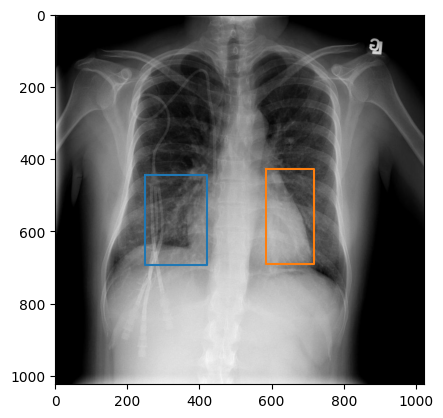

In [ ]:
demo_patient_id = val_series.values[2]
demo_img_path = DATASET_DIR + 'images/val/' + demo_patient_id + '.jpg'
demo_label_path = DATASET_DIR + 'labels/val/' + demo_patient_id + '.txt'

plt.imshow(cv2.imread(demo_img_path))

img_size = 1014
with open(demo_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))
        
        x, y, w, h = revert_bbox(rx, ry, rw, rh)
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [10]:
%%writefile config.yaml

path: '/kaggle/working/dataset' # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')

# Classes
names:
  0: pneumonia

Writing config.yaml


In [12]:
!pip install ultralytics

In [13]:
from ultralytics import YOLO

In [14]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 184MB/s]


In [84]:
results = model.train(data='config.yaml', epochs = 100)

Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

wandb: Currently logged in as: vladivashchuk. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train.cache... 5410 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5410/5410 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/dataset/labels/val.cache... 602 images, 0 backgrounds, 0 corrupt: 100%|██████████| 602/602 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.4G      1.978      1.975      1.927          2        640: 100%|██████████| 339/339 [01:32<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]


                   all        602        967      0.413      0.478      0.414      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.38G       1.95      1.886      1.861          2        640: 100%|██████████| 339/339 [01:04<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.89it/s]


                   all        602        967      0.504      0.527      0.484      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.38G      1.971      1.894      1.869          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.75it/s]


                   all        602        967      0.435      0.517      0.451      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.37G      1.955      1.885      1.877          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.91it/s]


                   all        602        967      0.499      0.527      0.503      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.38G      1.946      1.858      1.854          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.90it/s]


                   all        602        967      0.481      0.553      0.486      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.38G      1.928       1.84      1.841          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.83it/s]


                   all        602        967      0.476       0.56        0.5      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.38G      1.925       1.82      1.825          4        640: 100%|██████████| 339/339 [01:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]

                   all        602        967      0.492      0.578      0.503      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.37G      1.907      1.797      1.809          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]

                   all        602        967      0.516      0.541      0.513        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.38G      1.902      1.798      1.812          4        640: 100%|██████████| 339/339 [01:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        602        967       0.54      0.553      0.539      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.38G      1.887      1.783      1.795          4        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.90it/s]


                   all        602        967      0.486      0.516      0.471       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.38G      1.887      1.771      1.793          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.93it/s]


                   all        602        967        0.5      0.574      0.499      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.37G      1.891      1.775      1.786          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        602        967       0.49      0.586      0.502      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G      1.873      1.771      1.796          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        602        967      0.478      0.546      0.489      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.38G      1.863      1.751      1.792          4        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.89it/s]

                   all        602        967      0.487       0.57      0.513      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.38G       1.86       1.73      1.779          4        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.89it/s]

                   all        602        967      0.511      0.563      0.511      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.37G      1.857      1.736      1.782          4        640: 100%|██████████| 339/339 [01:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        602        967      0.484      0.559      0.486        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.38G      1.856      1.727      1.782          2        640: 100%|██████████| 339/339 [01:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.46it/s]


                   all        602        967      0.524      0.558      0.507        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.38G      1.851      1.702      1.773          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.83it/s]


                   all        602        967      0.496      0.569        0.5      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.38G      1.836      1.707      1.782          2        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.92it/s]


                   all        602        967       0.47      0.587      0.494      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.37G      1.837      1.697      1.775          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.90it/s]


                   all        602        967      0.493      0.583      0.506      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.38G      1.834       1.69       1.76          4        640: 100%|██████████| 339/339 [01:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        602        967      0.503      0.602      0.534      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.38G      1.831      1.679      1.767          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]


                   all        602        967      0.506      0.596      0.531      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.38G      1.827      1.683      1.777          2        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]

                   all        602        967      0.531      0.583      0.542      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.37G       1.82      1.664      1.746          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]

                   all        602        967      0.538      0.597      0.543      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.38G       1.81       1.67      1.739          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.71it/s]

                   all        602        967      0.523      0.608      0.543      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.38G      1.816      1.652      1.742          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        602        967       0.52      0.573      0.509      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.38G      1.799      1.647       1.73          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]


                   all        602        967       0.52      0.586      0.519      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.37G      1.797      1.643      1.733          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.71it/s]

                   all        602        967       0.54      0.588      0.549      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.38G      1.797      1.634      1.743          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        602        967      0.537      0.586      0.533      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.38G      1.797      1.626      1.735          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.87it/s]

                   all        602        967      0.518      0.564      0.533      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.38G      1.794      1.616       1.73          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.90it/s]


                   all        602        967      0.541      0.563      0.535      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.37G      1.786      1.615      1.732          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        602        967      0.529      0.597      0.541      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.38G      1.782      1.603       1.73          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]


                   all        602        967      0.535      0.582      0.536      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.38G      1.777      1.599       1.72          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        602        967      0.525      0.605      0.545      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.38G      1.769       1.59      1.711          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        602        967      0.528      0.578      0.551      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.37G      1.768      1.585      1.709          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.72it/s]


                   all        602        967      0.494      0.617      0.524      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.38G      1.774      1.585      1.719          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]

                   all        602        967      0.533      0.593      0.554      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.38G      1.759      1.575      1.699          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.83it/s]


                   all        602        967      0.524       0.62      0.534      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.38G      1.753      1.571      1.701          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.77it/s]

                   all        602        967      0.515      0.611      0.524      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.37G      1.747      1.556      1.708          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]

                   all        602        967      0.548      0.586      0.554      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.38G      1.746      1.541      1.695          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.43it/s]


                   all        602        967      0.552      0.584      0.563      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.38G      1.745      1.552      1.703          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.75it/s]


                   all        602        967      0.542      0.593      0.542      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.38G      1.738       1.53      1.687          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        602        967      0.555      0.572      0.546      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.37G      1.732       1.52      1.678          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


                   all        602        967      0.521      0.618      0.554      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.38G      1.729      1.528      1.681          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        602        967      0.538      0.607      0.544       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.38G      1.724      1.524      1.677          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.88it/s]


                   all        602        967      0.545      0.584       0.55      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.38G      1.713      1.512       1.67          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        602        967      0.531      0.609      0.546       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.37G      1.712      1.502      1.677          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        602        967      0.568      0.581      0.554       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.38G      1.701      1.495      1.669          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.48it/s]


                   all        602        967      0.583      0.592      0.549      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.38G      1.705      1.503      1.665          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.76it/s]


                   all        602        967      0.561      0.575      0.538      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G      1.693      1.488      1.653          5        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        602        967      0.538      0.567      0.546      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.37G      1.697      1.476      1.658          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


                   all        602        967      0.545      0.601      0.542      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.38G      1.688      1.454       1.65          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]

                   all        602        967      0.562      0.581      0.545       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.38G      1.675      1.452      1.653          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.87it/s]

                   all        602        967      0.533      0.594      0.538      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.38G      1.672      1.439      1.646          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


                   all        602        967      0.549      0.583      0.536      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.37G      1.669      1.436      1.649          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.91it/s]

                   all        602        967      0.531      0.592      0.539      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.38G      1.665      1.417      1.638          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]

                   all        602        967      0.564      0.577      0.552      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.38G      1.653      1.422      1.631          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]


                   all        602        967      0.549      0.571      0.546      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.38G      1.653      1.409      1.631          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]

                   all        602        967      0.546        0.6      0.534      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.37G       1.65      1.404      1.624          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.83it/s]


                   all        602        967      0.556      0.574      0.541      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.38G      1.636      1.396      1.618          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


                   all        602        967       0.56       0.57      0.534      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.38G      1.632      1.395      1.617          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


                   all        602        967      0.559      0.582      0.536       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.38G      1.638      1.385      1.613          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]

                   all        602        967      0.528      0.624      0.526      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.37G       1.63      1.378      1.609          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.88it/s]

                   all        602        967      0.555       0.58      0.533      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.38G      1.613       1.35       1.61          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        602        967      0.552      0.598      0.538       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.38G      1.613      1.355      1.604          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


                   all        602        967      0.516       0.62      0.533       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.38G      1.614      1.349      1.597          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.83it/s]


                   all        602        967      0.538       0.61      0.539      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.37G      1.594      1.341      1.594          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]

                   all        602        967      0.561      0.605      0.558      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.38G      1.593      1.318      1.584          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


                   all        602        967      0.552      0.587      0.539      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.38G      1.592      1.324       1.59          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.90it/s]


                   all        602        967      0.568      0.587      0.543      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.38G      1.583      1.306      1.584          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]

                   all        602        967      0.524      0.627      0.531      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.37G      1.579      1.306      1.583          3        640: 100%|██████████| 339/339 [01:04<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]

                   all        602        967      0.543      0.607      0.534      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.38G      1.572      1.297      1.567          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.38it/s]

                   all        602        967      0.547      0.594      0.536      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.38G      1.563      1.274      1.561          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.76it/s]


                   all        602        967      0.548      0.615      0.538      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.38G       1.55      1.275      1.561          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.90it/s]

                   all        602        967      0.538      0.596      0.526      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.37G      1.554      1.273       1.56          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.87it/s]

                   all        602        967      0.559      0.581      0.532      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.38G      1.547      1.263      1.553          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.92it/s]

                   all        602        967      0.547       0.59      0.527      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.38G       1.54       1.25      1.549          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]

                   all        602        967      0.535      0.607      0.527      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.38G      1.532      1.256      1.546          4        640: 100%|██████████| 339/339 [01:04<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.89it/s]


                   all        602        967      0.541      0.613      0.531      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.37G      1.524      1.237      1.542          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]

                   all        602        967      0.531      0.612      0.527      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G      1.526      1.238      1.539          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]

                   all        602        967      0.527       0.62      0.526        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.38G      1.506      1.232      1.526          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.70it/s]

                   all        602        967      0.547      0.585      0.522      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.38G      1.511      1.215      1.529          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.86it/s]

                   all        602        967      0.516      0.626      0.521      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.37G      1.513      1.206      1.531          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.91it/s]


                   all        602        967      0.536      0.603      0.527      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.38G      1.498      1.206      1.517          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.83it/s]

                   all        602        967      0.519      0.612      0.525      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.38G      1.493      1.191      1.522          5        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.81it/s]

                   all        602        967      0.515      0.636      0.532      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.38G      1.484      1.183      1.505          2        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.75it/s]

                   all        602        967      0.539      0.605      0.526      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.37G      1.486      1.185      1.513          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.96it/s]

                   all        602        967      0.529      0.608      0.524      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.38G      1.484      1.183       1.51          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        602        967      0.535      0.604      0.517      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.38G       1.47      1.164      1.495          3        640: 100%|██████████| 339/339 [01:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.67it/s]

                   all        602        967      0.514      0.624      0.517      0.191


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.38G      1.461       1.16      1.493          3        640: 100%|██████████| 339/339 [01:06<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


                   all        602        967      0.519      0.626      0.521      0.191
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 41, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

91 epochs completed in 1.738 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


                   all        602        967      0.553      0.586      0.564      0.225
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train2


lr/pg0,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
lr/pg1,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
lr/pg2,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
metrics/mAP50(B),▁▃▅▅▄▅▆▆▅▇▇▆█▇▇███▇████▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▆
metrics/mAP50-95(B),▁▂▄▅▄▆▆▅▆▇▇▆█▆▇█▇█▇█▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄
metrics/precision(B),▁▂▄▄▄▄▄▆▃▅▆▅▆▅▆▆▆▇▆▅▆█▆▆▆▇▇▆▇▆▇▆▇▇▆▆▆▅▆▅
metrics/recall(B),▁▃▄▅▃▆▅▅▆▆▆▅▆▅▆▅▆▆▆▇▇▆▅▆▆▅▅▇▆▇▆▇▇▆▇▇▇█▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,███▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁


In [96]:
def plot_val_pred(demo_patient_id, verbose=True, split='val'):
    demo_img_path = DATASET_DIR + f'images/{split}/' + demo_patient_id + '.jpg'
    demo_label_path = DATASET_DIR + f'labels/{split}/' + demo_patient_id + '.txt'

    res = model(demo_img_path, verbose=verbose)
    if verbose:
        print(res[0].probs)
        print(res[0].boxes.xywh)

    plt.imshow(cv2.imread(demo_img_path))

    img_size = 1014
    with open(demo_label_path, "r") as f:
        for line in f:
            if verbose:
                print(line)
            class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))

            x, y, w, h = revert_bbox(rx, ry, rw, rh)
            plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], c='blue')

    for box in res[0].boxes.xywh.cpu():
        px, py, pw, ph = box
        plt.plot([px-pw/2, px-pw/2, px+pw/2, px+pw/2, px-pw/2], [py-ph/2, py+ph/2, py+ph/2, py-ph/2, py-ph/2], c='orange')

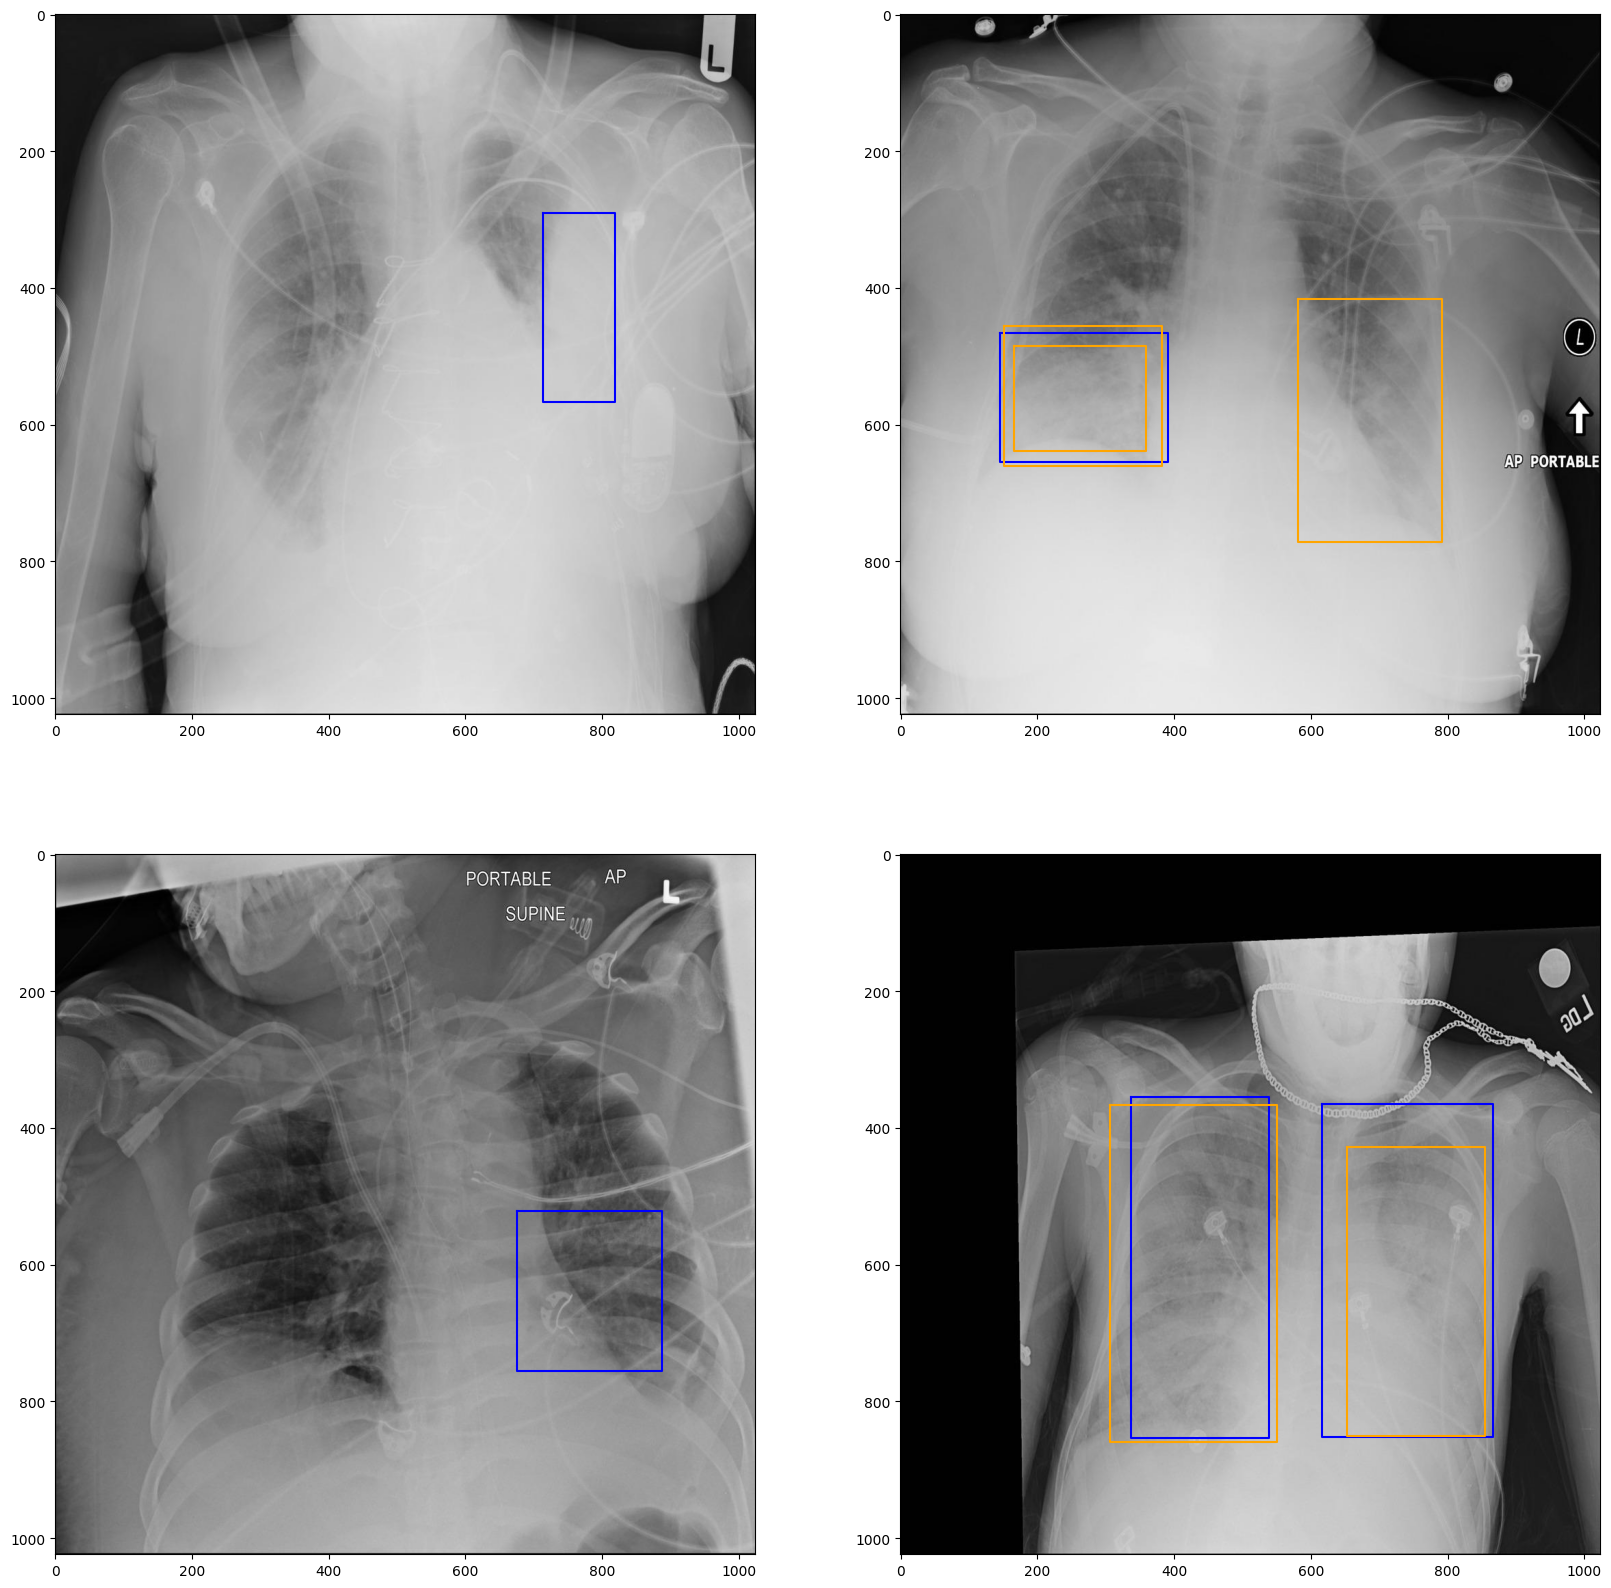

In [97]:
def random_value(series):
    return series.iloc[random.randrange(0, len(series))]

def plot_examples(series, rows = 5, cols = 2, split='val'):
    plt.figure(figsize=(10*cols,10*rows))
    # plot_val_pred(random_value(val_series), verbose=False)
    for h in range(rows):
        for w in range(cols):
            plt.subplot(rows, cols, h*2+w+1)
            plot_val_pred(random_value(series), verbose=False, split=split)
            
plot_examples(val_series, 2, 2, 'val')

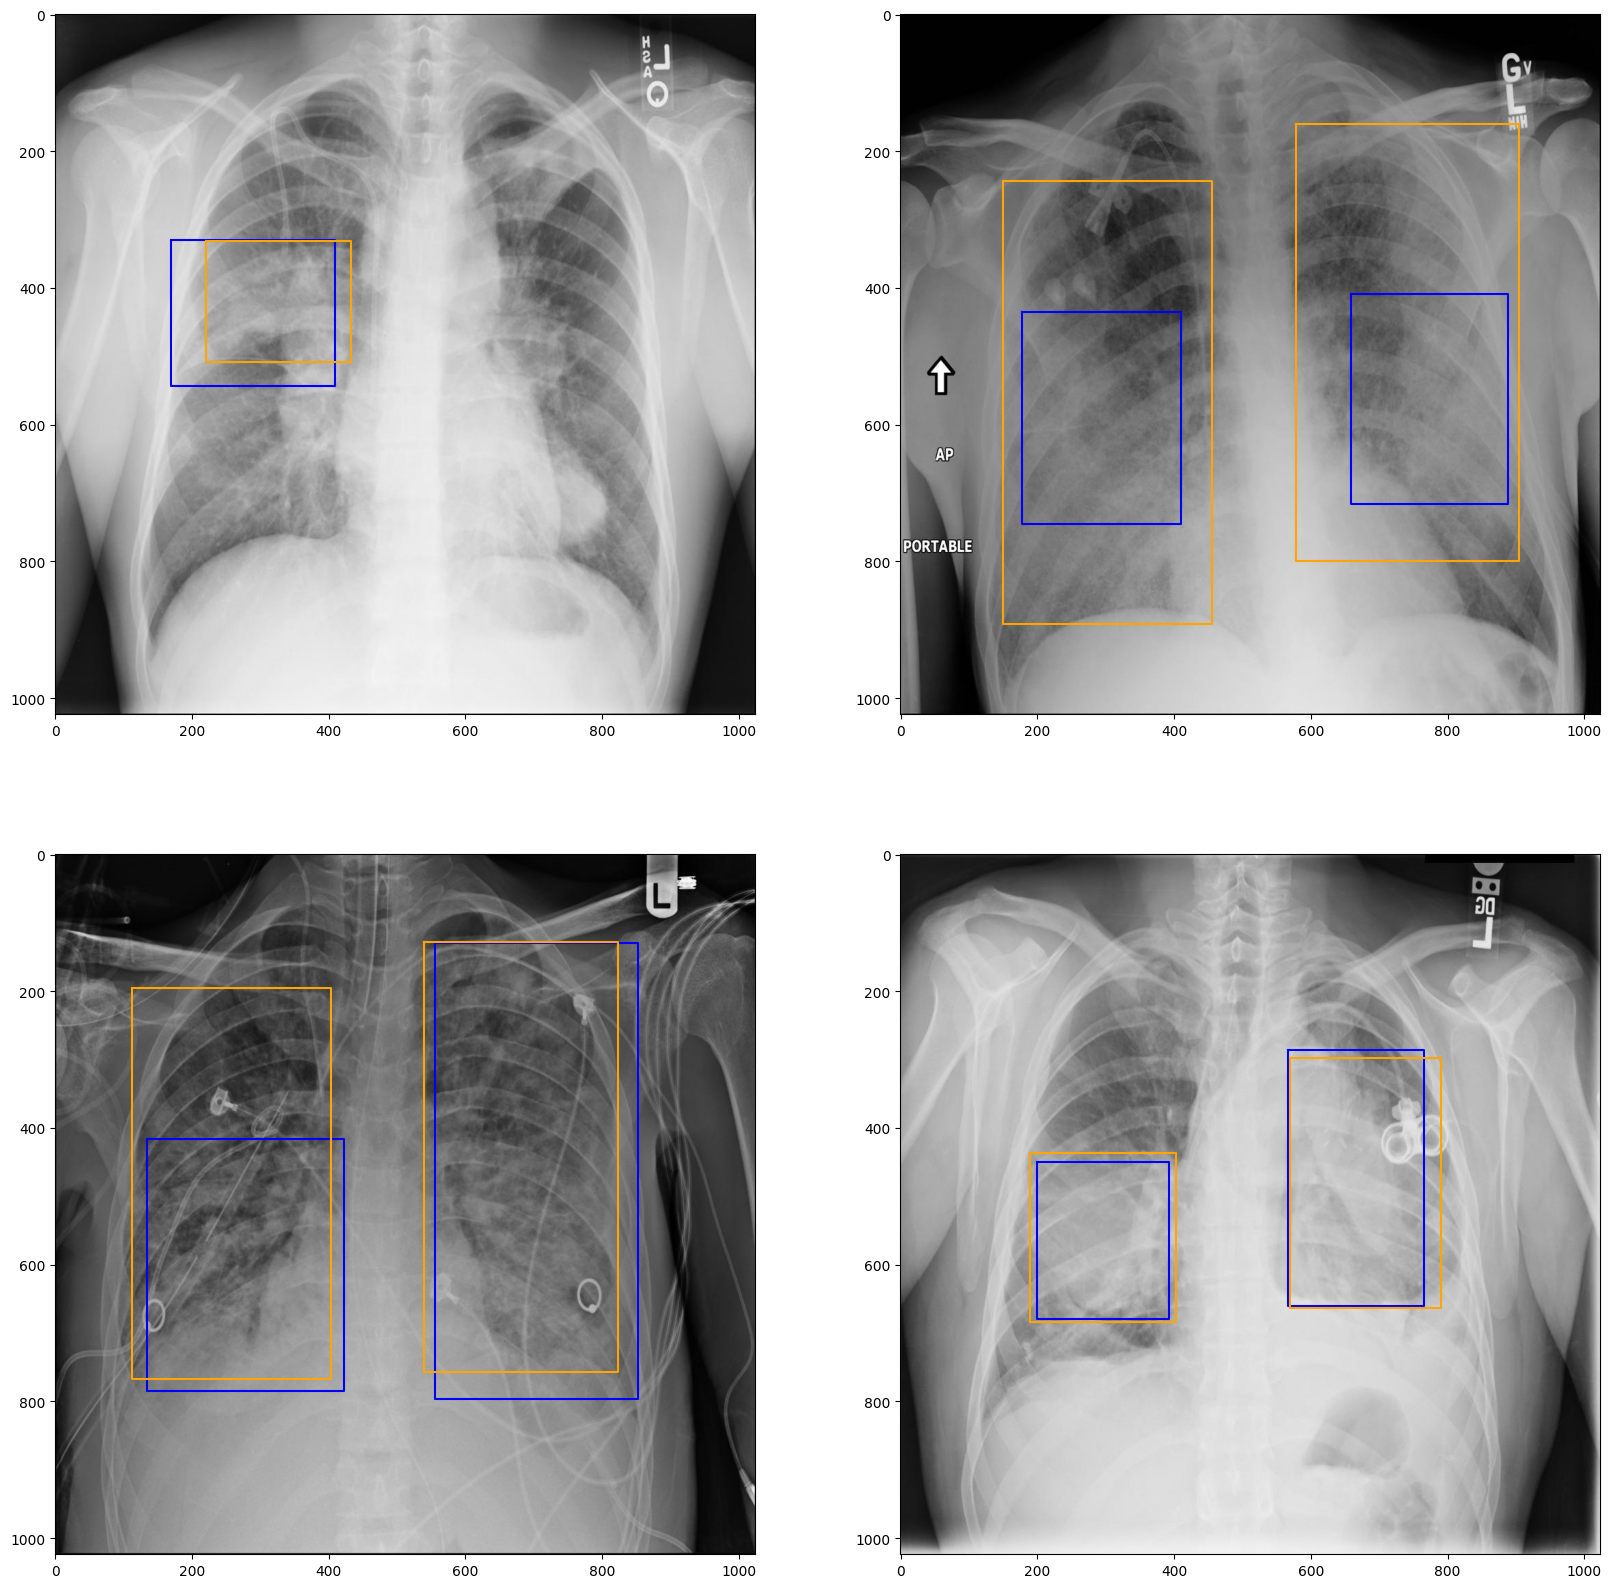

In [100]:
plot_examples(train_series, 2, 2, 'train')

In [115]:
for file in tqdm(os.listdir(TEST_SRC_DIR)):
    src_path = TEST_SRC_DIR + file
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(TEST_IMG_DIR + os.path.splitext(file)[0] + '.jpg')

In [135]:
results = model(TEST_IMG_DIR, verbose=False)


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



In [174]:
def get_id_from_path(path):
    return os.path.splitext(os.path.basename(path))[0]

print(get_id_from_path(results[1].path))
print(results[1].boxes.xywh)
print(results[1].boxes.conf)

0005d3cc-3c3f-40b9-93c3-46231c3eb813
tensor([[385.8204, 280.5793, 105.6767, 156.5484]], device='cuda:0')
tensor([0.2664], device='cuda:0')


In [175]:
with open('submission.csv', 'w') as file:
    file.write("patientId,PredictionString\n")

    for result in tqdm(results):
        line = get_id_from_path(result.path) + ','
        
        for conf, xywh in zip(result.boxes.conf, result.boxes.xywh):
            x, y, w, h = xywh
            line += f"{conf:.2f} {x:.2f} {y:.2f} {w:.2f} {h:.2f} "
            
        line = line.strip()
        file.write(line+"\n")

100%|██████████| 3000/3000 [00:00<00:00, 5675.21it/s]
